# Описание проекта

Необходимо было подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий. 

Модель предсказывает коэффициент восстановления золота из золотосодержащей руды по параметрам добычи и очистки.

Модель должна помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Оглавление
1. [Подготовка данных](#step1)
2. [Анализ данных](#step2)
3. [Модель](#step3)
4. [Общий вывод](#step4)

<div align='justify'> <i> Загружаем необходимые библиотеки и настраиваем Jupyter.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from scipy import stats as st

<div align="justify"> <i> Задаем константы и пишем функции, которые будем использовать многократно на протяжении всего проекта.

In [2]:
# начальное состояние для моделей
RANDOM_STATE = 12345

# цвета и палетка для графиков
COLOR = '#a52a2a'
COLOR_LINE = '#e29072'
PALETTE='rocket'

# функция расчета интервала вывода для гистограмм
# column - колонка с набором данных
# coeff - коэффициент при интерквартильном размахе
def get_range(column, coeff):
    iqr = column.quantile(0.75)-column.quantile(0.25)
    low = column.quantile(0.25)-coeff*iqr
    high = column.quantile(0.75)+coeff*iqr
    interval = (low, high)
    return interval

# 1. Подготовка данных  <a name="step1"></a>

<div align="justify"> <i> Загрузим данные с параметрами добычи и очистки золотосодержащей руды, полученные от компании «Цифра».

In [3]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

<div align="justify"> <i> Изучим загруженные данные.<br>
Предварительно добавим все наборы данных в единый список.

In [4]:
gold_recovery_list = [gold_recovery_train, gold_recovery_test, gold_recovery_full]
gold_recovery_names = ['Train', 'Test', 'Full']

In [5]:
for gold_recovery, gold_recovery_name in zip(gold_recovery_list, gold_recovery_names):
    print(gold_recovery_name)
    print()
    display(gold_recovery.info())
    print()
    display(gold_recovery.head())
    print()
    display(gold_recovery.describe())
    print()

Train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant      

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927



Test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rou

None

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593



Full

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant      

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


<div align="justify"> <i> Вычислим эффективность обогащения чернового концентрата (rougher.output.recovery) на обучающей выборке и проверим с уже рассчитанными данными. <br>
Для этого сначала удалим строки с пустыи значениями.

In [6]:
gold_recovery_train_temp = gold_recovery_train.dropna().copy()
gold_recovery_train_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  11017 non-null object
final.output.concentrate_ag                           11017 non-null float64
final.output.concentrate_pb                           11017 non-null float64
final.output.concentrate_sol                          11017 non-null float64
final.output.concentrate_au                           11017 non-null float64
final.output.recovery                                 11017 non-null float64
final.output.tail_ag                                  11017 non-null float64
final.output.tail_pb                                  11017 non-null float64
final.output.tail_sol                                 11017 non-null float64
final.output.tail_au                                  11017 non-null float64
primary_cleaner.input.sulfate                         11017 non-null float64
primary_cleaner.input.depressant             

<div align="justify"> <i> Для вычисления эффективности обогащения чернового концентрата сделаем функцию get_rougher_output_recovery и применим ее.

In [7]:
# c — доля золота в концентрате после флотации/очистки;
# f — доля золота в сырье/концентрате до флотации/очистки;
# t — доля золота в отвальных хвостах после флотации/очистки.
def get_rougher_output_recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    
    if f*(c-t):
        return (c*(f-t))/(f*(c-t))*100
    else:
        return 0

In [8]:
gold_recovery_train_temp['rougher.output.recovery.new'] = gold_recovery_train_temp.apply(get_rougher_output_recovery, axis=1)
gold_recovery_train_temp['rougher.output.recovery.new'].describe()

count    11017.000000
mean        82.741888
std         13.590523
min         -0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery.new, dtype: float64

In [9]:
display(gold_recovery_train_temp[['rougher.output.recovery', 'rougher.output.recovery.new']].head())
mean_squared_error(gold_recovery_train_temp['rougher.output.recovery'], gold_recovery_train_temp['rougher.output.recovery.new'])

,rougher.output.recovery,rougher.output.recovery.new
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


2.0687703599800886e-28

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Изначально предоставленные данные по эффективности обогащения чернового концентрата верны. MAE предоставленных данных с расчитанными составило ~0.  <br>

<div align="justify"> <i> Проанализируем признаки, недоступные в тестовой выборке.

In [10]:
set(gold_recovery_full.columns)-set(gold_recovery_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> 1. Все параметры, недоступные в тестовой выборке относятся к расчетным и выходным параметрам для каждого из этапа обработки. <br>
2. Полностью отутствуют данные о финальных характеристиках. <br>
3. Отсутствующие в тестовой выборке данные можно взять из финального набора данных, если они в нем есть, или же попытаться заполнить. <br>
4. Recovery можно рассчитать, т.к. у нас есть формула.

<div align="justify"> <i> Проведем предобработку данных. <br>
Для начала преобразуем временные данные в правильный тип.

In [11]:
for gold_recovery, gold_recovery_name in zip(gold_recovery_list, gold_recovery_names):
    gold_recovery['date'] = pd.to_datetime(gold_recovery['date'], format='%Y-%m-%d %H:%M:%S')
    print(gold_recovery_name)
    display(gold_recovery['date'].head())

Train


0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
3   2016-01-15 03:00:00
4   2016-01-15 04:00:00
Name: date, dtype: datetime64[ns]

Test


0   2016-09-01 00:59:59
1   2016-09-01 01:59:59
2   2016-09-01 02:59:59
3   2016-09-01 03:59:59
4   2016-09-01 04:59:59
Name: date, dtype: datetime64[ns]

Full


0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
3   2016-01-15 03:00:00
4   2016-01-15 04:00:00
Name: date, dtype: datetime64[ns]

<div align="justify"> <i> Ограничим количество колонок в обучающей выборке теми признакми, которые есть в тестовой. Но при этом оставим целевые признаки rougher.output.recovery и final.output.recovery. <br>
Временно оставим 'rougher.output.concentrate_au' и 'rougher.output.tail_au', они нам понадобятся при расчете rougher.output.recovery в строках с пропущенными значениями. 

In [12]:
list_train_columns = list(gold_recovery_test.columns)+['rougher.output.recovery', 'final.output.recovery', 'rougher.output.concentrate_au', 'rougher.output.tail_au']

gold_recovery_train = gold_recovery_train[list_train_columns]
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 57 columns):
date                                          16860 non-null datetime64[ns]
primary_cleaner.input.sulfate                 15553 non-null float64
primary_cleaner.input.depressant              15598 non-null float64
primary_cleaner.input.feed_size               16860 non-null float64
primary_cleaner.input.xanthate                15875 non-null float64
primary_cleaner.state.floatbank8_a_air        16820 non-null float64
primary_cleaner.state.floatbank8_a_level      16827 non-null float64
primary_cleaner.state.floatbank8_b_air        16820 non-null float64
primary_cleaner.state.floatbank8_b_level      16833 non-null float64
primary_cleaner.state.floatbank8_c_air        16822 non-null float64
primary_cleaner.state.floatbank8_c_level      16833 non-null float64
primary_cleaner.state.floatbank8_d_air        16821 non-null float64
primary_cleaner.state.floatbank8_d_level      16833 non-

<div align="justify"> <i> Также, временно добавим 'rougher.output.concentrate_au' и 'rougher.output.tail_au' в тестовую выборку для rougher.output.recovery.

In [13]:
gold_recovery_test['rougher.output.concentrate_au'] = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])].reset_index()['rougher.output.concentrate_au']
gold_recovery_test['rougher.output.tail_au'] = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])].reset_index()['rougher.input.feed_au']
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 55 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
ro

<div align="justify"> <i> Теперь заполним пропуски во входных данных обучающей и тестовой выборках медианами из общей выборки.

In [14]:
list_columns_temp = [x for x in list(gold_recovery_test.columns) if x !='date']

for gold_recovery in [gold_recovery_train, gold_recovery_test]:
    for column in list_columns_temp:
        gold_recovery[column].fillna(gold_recovery_full[column].median(), inplace=True) 

for gold_recovery, gold_recovery_name in zip([gold_recovery_train, gold_recovery_test], ['Train', 'Test']):
    print(gold_recovery_name)
    print()
    display(gold_recovery.info())
    print()
    display(gold_recovery.describe())

Train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 57 columns):
date                                          16860 non-null datetime64[ns]
primary_cleaner.input.sulfate                 16860 non-null float64
primary_cleaner.input.depressant              16860 non-null float64
primary_cleaner.input.feed_size               16860 non-null float64
primary_cleaner.input.xanthate                16860 non-null float64
primary_cleaner.state.floatbank8_a_air        16860 non-null float64
primary_cleaner.state.floatbank8_a_level      16860 non-null float64
primary_cleaner.state.floatbank8_b_air        16860 non-null float64
primary_cleaner.state.floatbank8_b_level      16860 non-null float64
primary_cleaner.state.floatbank8_c_air        16860 non-null float64
primary_cleaner.state.floatbank8_c_level      16860 non-null float64
primary_cleaner.state.floatbank8_d_air        16860 non-null float64
primary_cleaner.state.floatbank8_d_level      168

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery,rougher.output.concentrate_au,rougher.output.tail_au
count,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,...,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,14287.000000,15339.000000,16860.000000,16860.000000
mean,130.398466,8.579597,7.297285,0.847403,1521.478613,-505.799656,1524.060684,-507.334344,1514.543606,-507.082984,...,15.774848,-500.228306,12.370246,-498.961218,18.426611,-521.692393,82.394201,67.213166,17.414194,1.769884
std,43.707173,3.561091,0.619166,0.406926,379.632664,77.564691,380.810803,79.767328,396.066714,78.760527,...,6.817763,76.789232,6.205067,81.941334,6.937085,76.991452,15.096808,11.960446,6.907393,0.681149
min,0.000003,0.000000,1.080000,0.000005,0.000000,-800.037388,0.000000,-800.409770,0.000000,-800.362914,...,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526,0.000000,0.000000,0.000000,0.020676
25%,105.698879,6.028747,6.940000,0.592487,1504.162089,-500.413514,1503.035817,-500.490252,1500.721701,-500.858202,...,10.980219,-500.526793,8.932437,-500.146651,13.982492,-501.057632,79.818372,62.625685,17.461255,1.392400
50%,135.969823,8.018173,7.285000,0.891656,1601.126086,-499.953123,1601.105993,-499.986863,1600.895689,-499.952956,...,15.989561,-499.792372,11.042235,-499.935758,18.027890,-500.104482,85.235997,67.644601,19.656569,1.808567
75%,156.728392,11.004224,7.700000,1.089204,1699.296724,-499.413600,1699.982559,-499.438839,1700.213827,-498.905249,...,19.997150,-496.677756,15.967104,-498.674800,24.984526,-499.568563,90.131691,72.824595,21.218314,2.107259
max,251.999948,40.000000,10.470000,6.027907,2079.531340,-330.134203,2361.414084,-336.237097,2042.072583,-221.857683,...,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927,100.000000,100.000000,28.522811,9.688980


Test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 55 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null floa

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.concentrate_au,rougher.output.tail_au
count,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,...,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000
mean,169.010155,8.460336,7.264651,1.309624,1482.312888,-509.032947,1487.217751,-511.711873,1468.853835,-509.714548,...,13.150626,-476.402495,12.315935,-512.174402,9.475136,-505.003986,16.682343,-512.318207,19.254850,8.682098
std,48.741585,3.272295,0.611526,0.686830,310.089971,61.257228,312.851760,67.050078,309.632739,62.588255,...,4.299230,105.412110,3.760040,58.787697,3.308892,68.692357,5.397568,69.827170,6.186778,2.822244
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706,0.000000,0.000000
25%,141.330501,6.468654,6.885625,0.893229,1497.244023,-500.453676,1497.194415,-500.933376,1438.144447,-501.293883,...,11.888077,-500.416905,10.133598,-500.875187,7.991788,-500.222374,13.016156,-500.828740,19.457679,7.747676
50%,172.931569,8.018173,7.259333,1.147030,1555.113412,-499.995748,1553.494638,-500.063470,1546.621365,-500.075469,...,14.951357,-499.639950,12.083931,-500.044706,9.983305,-500.000307,16.007627,-500.043364,20.813812,9.444042
75%,205.165772,10.002083,7.650000,1.705499,1601.663393,-499.576625,1601.742913,-499.325756,1600.779636,-499.013265,...,15.938679,-401.623704,15.017197,-499.299273,11.992018,-499.723275,21.008868,-499.401579,22.338619,10.372205
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593,28.824507,13.731330


<div align="justify"> <i> Из финальной выборки в тестовую добавим целевые признаки rougher.output.recovery и final.output.recovery. <br>

In [15]:
gold_recovery_test['rougher.output.recovery'] = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])].reset_index()['rougher.output.recovery']
gold_recovery_test['final.output.recovery'] = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])].reset_index()['final.output.recovery']
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 57 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
ro

<div align="justify"> <i> Теперь рассчитаем rougher.output.recovery воспользовавших уже имеющейся формулой.

In [16]:
gold_recovery_test.loc[gold_recovery_test['rougher.output.recovery'].isnull(), 'rougher.output.recovery'] = gold_recovery_test[gold_recovery_test['rougher.output.recovery'].isnull()].apply(get_rougher_output_recovery, axis=1)
gold_recovery_train.loc[gold_recovery_train['rougher.output.recovery'].isnull(), 'rougher.output.recovery'] = gold_recovery_train[gold_recovery_train['rougher.output.recovery'].isnull()].apply(get_rougher_output_recovery, axis=1)

for gold_recovery, gold_recovery_name in zip([gold_recovery_train, gold_recovery_test], ['Train', 'Test']):
    print(gold_recovery_name)
    print()
    display(gold_recovery.info())

Train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 57 columns):
date                                          16860 non-null datetime64[ns]
primary_cleaner.input.sulfate                 16860 non-null float64
primary_cleaner.input.depressant              16860 non-null float64
primary_cleaner.input.feed_size               16860 non-null float64
primary_cleaner.input.xanthate                16860 non-null float64
primary_cleaner.state.floatbank8_a_air        16860 non-null float64
primary_cleaner.state.floatbank8_a_level      16860 non-null float64
primary_cleaner.state.floatbank8_b_air        16860 non-null float64
primary_cleaner.state.floatbank8_b_level      16860 non-null float64
primary_cleaner.state.floatbank8_c_air        16860 non-null float64
primary_cleaner.state.floatbank8_c_level      16860 non-null float64
primary_cleaner.state.floatbank8_d_air        16860 non-null float64
primary_cleaner.state.floatbank8_d_level      168

None

Test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 57 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null floa

None

<div align="justify"> <i> Удалим временно добавленные 'rougher.output.concentrate_au' и 'rougher.output.tail_au' из обучающей и тестовой выборок. <br>
Также в связи с тем, что мы не знаем как рассчитывать правильно final.output.recovery учитывая все стадии обработки руды, удалим строки с пустыми значениями final.output.recovery в обучающей и тестовой выборках.

In [17]:
for gold_recovery, gold_recovery_name in zip([gold_recovery_train, gold_recovery_test], ['Train', 'Test']):
    del(gold_recovery['rougher.output.concentrate_au'])
    del(gold_recovery['rougher.output.tail_au'])
    
    gold_recovery.dropna(inplace=True)
    
    print(gold_recovery_name)
    print()
    display(gold_recovery.info())

Train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15339 entries, 0 to 16859
Data columns (total 55 columns):
date                                          15339 non-null datetime64[ns]
primary_cleaner.input.sulfate                 15339 non-null float64
primary_cleaner.input.depressant              15339 non-null float64
primary_cleaner.input.feed_size               15339 non-null float64
primary_cleaner.input.xanthate                15339 non-null float64
primary_cleaner.state.floatbank8_a_air        15339 non-null float64
primary_cleaner.state.floatbank8_a_level      15339 non-null float64
primary_cleaner.state.floatbank8_b_air        15339 non-null float64
primary_cleaner.state.floatbank8_b_level      15339 non-null float64
primary_cleaner.state.floatbank8_c_air        15339 non-null float64
primary_cleaner.state.floatbank8_c_level      15339 non-null float64
primary_cleaner.state.floatbank8_d_air        15339 non-null float64
primary_cleaner.state.floatbank8_d_level      153

None

Test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5414 entries, 0 to 5855
Data columns (total 55 columns):
date                                          5414 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5414 non-null float64
primary_cleaner.input.depressant              5414 non-null float64
primary_cleaner.input.feed_size               5414 non-null float64
primary_cleaner.input.xanthate                5414 non-null float64
primary_cleaner.state.floatbank8_a_air        5414 non-null float64
primary_cleaner.state.floatbank8_a_level      5414 non-null float64
primary_cleaner.state.floatbank8_b_air        5414 non-null float64
primary_cleaner.state.floatbank8_b_level      5414 non-null float64
primary_cleaner.state.floatbank8_c_air        5414 non-null float64
primary_cleaner.state.floatbank8_c_level      5414 non-null float64
primary_cleaner.state.floatbank8_d_air        5414 non-null float64
primary_cleaner.state.floatbank8_d_level      5414 non-null floa

None

<div align="justify"> <i> 

### Выводы

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> 1. Изначально предоставленные данные по эффективности обогащения чернового концентрата верны. MAE предоставленных данных с расчитанными составило ~0. <br>
2.  В тестовой выборке отсутствуют значительная часть колонок. Все параметры, недоступные в тестовой выборке относятся к расчетным и выходным параметрам для каждого из этапа обработки. В тестовой выборке полностью отутствуют данные о финальных характеристиках. <br>
3. В загруженных данных обнаружено несоответсвие формата данных времени. Колонка 'date' приведена к формату даты. <br>
4. Обнаруженные пропуски заполнены медианами. <br>
5. Отсутствующие в тестовой выборке целевые признаки взяты из финального набора данных. <br>
6. Оставшиеся пропущенные значения целевого признака rougher.output.recovery рассчитаны по формуле.<br>
7. Также в связи с тем, что мы не знаем как рассчитывать правильно final.output.recovery учитывая все стадии обработки руды, удалены строки с пустыми значениями final.output.recovery в обучающей и тестовой выборках. <br>
    
Таким образом, выполнена подготовка данных к дальнейшему анализу и созданию модели.

# 2. Анализ данных <a name="step2"></a>

<div align="justify"> <i> Рассмотрим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки руды.

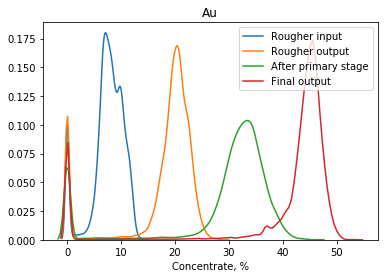

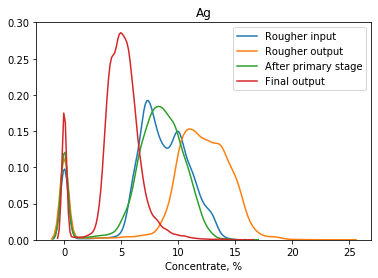

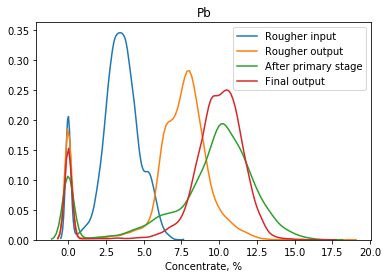

In [18]:
for payments_number in range(0, 5):
    for stage, stage_name in zip([rougher_input, rougher_output, primary, final],
                                ['Rougher input', 'Rougher output', 'After primary stage', 'Final output']):
        ax = sns.distplot(gold_recovery_full[stage],
                          hist = False,
                          label=stage_name)
        ax.set(xlabel='Concentrate, %')
plt.title(element_name)
plt.show()
        

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> 1. Концентрация золота после каждого этапа обработки растет. Рост практически равномерен, следовательно выделить наиболее важный этап невозможно, каждый этап в равной степени важен при обработке. <br>
2. Концентрация серебра на этапе флотации увеличивается, после этапов очистки уменьшается, и в итоге после всех этапов обработки имеет наименьшее значение. <br>
3. Концентрация свинца также растет от первого этапа и далее, кроме последнего. Второй этап очистки практически никак не влияет на концентрацию свинца. <br>
4. На всех распределениях элементов есть аномальные замеры концентраций с нулевыми значениями. Возможно это простои в работе, когда в аппарате по переработке нет руды. <br>

<div align="justify"> <i> Сравним распределения размеров гранул сырья (feed size) на обучающей и тестовой выборках на этапах флотации и очистки.

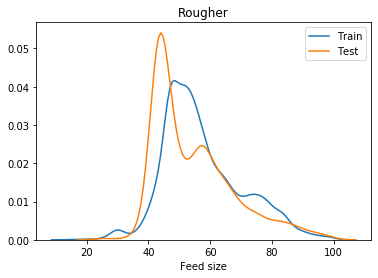

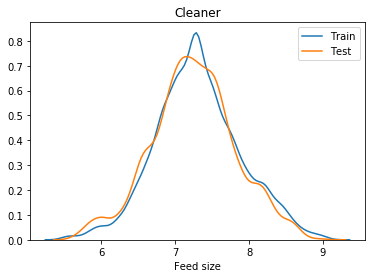

In [19]:
for stage, stage_name in zip(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'],
                             ['Rougher', 'Cleaner']):
    for gold_recovery, set_name in zip([gold_recovery_train, gold_recovery_test], ['Train', 'Test']):
        ax = sns.distplot(gold_recovery[stage],
                     hist = False,
                     bins=np.histogram_bin_edges(gold_recovery[stage], bins='sturges'),
                     kde_kws={'clip':get_range(gold_recovery[stage], 2)},
                     label=set_name)
    ax.set(xlabel='Feed size')
    plt.title(stage_name)
    plt.show()

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Распределения размеров гранул сырья (feed size) на обучающей и тестовой выборках на этапах флотации и очистки находятся в одном и том же диапазоне, поэтому разделение на обучающую и тестовую выборки сделано верно. <br>

<div align="justify"> <i> Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

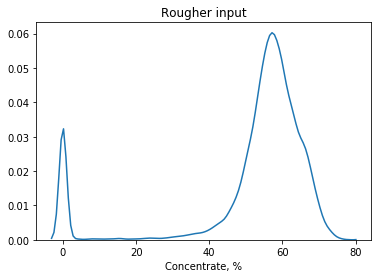

Количество нулевых значений = 1528


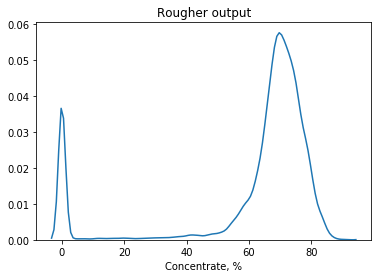

Количество нулевых значений = 1953


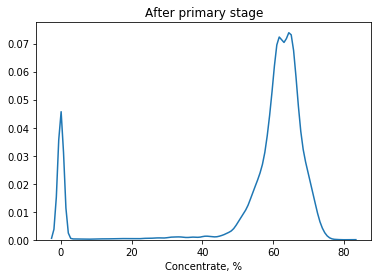

Количество нулевых значений = 1626


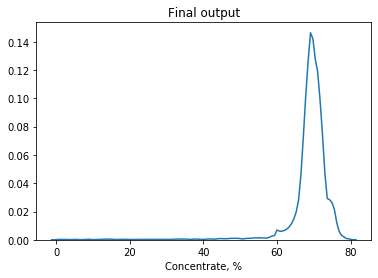

Количество нулевых значений = 1613


In [20]:
for stage_name, au, ag, pb, sol in zip(['Rougher input', 'Rougher output', 'After primary stage', 'Final output'],
                                                                       ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],
                                                                       ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],
                                                                       ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'],
                                                                       ['rougher.input.feed_sol', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']):
       
    gold_recovery_full_temp = gold_recovery_full.copy()
    gold_recovery_full_temp['sum'] = gold_recovery_full_temp[au]+gold_recovery_full_temp[ag]+gold_recovery_full_temp[pb]+gold_recovery_full_temp[sol]
    ax = sns.distplot(gold_recovery_full_temp['sum'],
                      hist = False)
    ax.set(xlabel='Concentrate, %')
    plt.title(stage_name)
    plt.show()
    print(f"Количество нулевых значений = {len(gold_recovery_full_temp[gold_recovery_full_temp['sum']==0]['sum'])}")

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Как указывалось выше на всех распределениях элементов есть аномальные замеры концентраций с нулевыми значениями. Они так же есть и на распределениях суммарных концетраций, значит это одни и те же временные замеры. Если рассмотреть их, то большинство идет друг за другом, что еще больше склоняет к теории, о том, что в это время в аппарате нет руды. Возможно ремонтные работы или профилактические, может отсутствие сырья. <br>
Удалим эти значения из тестовой и обучащей выборок.<br>
Остальные выбросы, которые можно увидеть, трогать не будем. Т.к. это и есть реальная концентрация. И нам важно, чтобы модель умела и их тоже обрабатывать. Если их убрать из модели, то получится, что у нас она станет как бы искаусственной. Т.е. будет работать только в небольших диапазонах - потому что обучалась только в них.

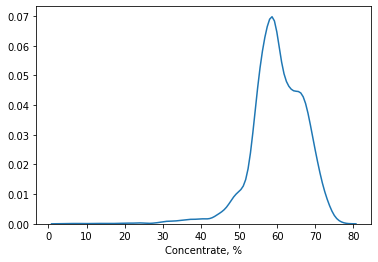

Количество нулевых значений = 0


In [21]:
gold_recovery_test = gold_recovery_test[gold_recovery_test['rougher.input.feed_au'] != 0]
gold_recovery_train = gold_recovery_train[gold_recovery_train['rougher.input.feed_au'] != 0]

gold_recovery_test_temp = gold_recovery_test.copy()
gold_recovery_test_temp['sum'] = gold_recovery_test_temp['rougher.input.feed_au']+gold_recovery_test_temp['rougher.input.feed_ag']+gold_recovery_test_temp['rougher.input.feed_pb']+gold_recovery_test_temp['rougher.input.feed_sol']
ax = sns.distplot(gold_recovery_test_temp['sum'],
                  hist = False)
ax.set(xlabel='Concentrate, %')
plt.show()
print(f"Количество нулевых значений = {len(gold_recovery_test_temp[gold_recovery_test_temp['sum']==0]['sum'])}")

### Выводы

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> 
1. Концентрация золота после каждого этапа обработки растет. Рост практически равномерен, следовательно выделить наиболее важный этап невозможно, каждый этап в равной степени важен при обработке. В отличии от золота, этапы обработки по разному влияют на содержание серебра и свинца. <br>
2. Распределения размеров гранул сырья (feed size) на обучающей и тестовой выборках на этапах флотации и очистки находятся в одном и том же диапазоне, поэтому разделение на обучающую и тестовую выборки сделано верно. <br>
3. На всех распределениях элементов есть аномальные замеры концентраций с нулевыми значениями. Они так же есть и на распределениях суммарных концетраций, значит это одни и те же временные замеры. Если рассмотреть их, то большинство идет друг за другом, что склоняет к теории, о том что в это время в аппарате нет руды, простои в работе. Возможно ремонтные работы или профилактические, может отсутствие сырья для очистки. <br>

# 3. Модель <a name="step3"></a>

<div align="justify"> <i> Напишим функции для вычисления sMAPE и итогового sMAPE.

In [22]:
def get_sMAPE(targets, predictions):
    sum_errors = 0
    
    for traget, prediction in zip(targets, predictions):
        dividend = abs(traget-prediction)
        divisor = (abs(traget)+abs(prediction))/2
        sum_errors += dividend/divisor
    
    sMAPE = sum_errors/len(targets)*100
    return sMAPE

In [23]:
def get_final_sMAPE(sMAPE_rougher, sMAPE_final_study):
    final_sMAPE = 0.25*sMAPE_rougher+0.75*sMAPE_final_study
    return final_sMAPE

<div align="justify"> <i> Применим make_scorer, чтобы сделать get_sMAPE метрикой.

In [24]:
sMAPE_scorer = make_scorer(get_sMAPE)

<div align="justify"> <i> Разобъем на features и target. При этом для стадии флотации уберем из признаков, признаки для этапа очистки. <br>

In [25]:
features_train_rougher_recovery = gold_recovery_train[['rougher.input.feed_pb', 'rougher.input.feed_rate',
                                    'rougher.input.feed_size', 'rougher.input.feed_sol',
                                    'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
                                    'rougher.input.floatbank10_xanthate',
                                    'rougher.input.floatbank11_sulfate',
                                    'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
                                    'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
                                    'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
                                    'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
                                    'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
                                    'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
                                    'rougher.state.floatbank10_f_level']]
target_train_rougher_recovery = gold_recovery_train['rougher.output.recovery']

features_train = gold_recovery_train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_train_final_recovery = gold_recovery_train['final.output.recovery']
                    
features_test_rougher_recovery = gold_recovery_train[['rougher.input.feed_pb', 'rougher.input.feed_rate',
                                    'rougher.input.feed_size', 'rougher.input.feed_sol',
                                    'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
                                    'rougher.input.floatbank10_xanthate',
                                    'rougher.input.floatbank11_sulfate',
                                    'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
                                    'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
                                    'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
                                    'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
                                    'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
                                    'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
                                    'rougher.state.floatbank10_f_level']]
target_test_rougher_recovery = gold_recovery_test['rougher.output.recovery']

features_test = gold_recovery_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_test_final_recovery = gold_recovery_test['final.output.recovery']

<div align="justify"> <i> Обучим модель случайного леса для прогноза rougher.output.recovery и оценим ее качество кросс-валидацией. <br>

In [26]:
model_rougher_RandFor = RandomForestRegressor(random_state=RANDOM_STATE)
model_rougher_RandFor_params = {'n_estimators' : range(150, 220, 5), 'max_features': range(12, 18, 1)}
grid_rougher_RandFor = GridSearchCV(model_rougher_RandFor, model_rougher_RandFor_params, scoring=sMAPE_scorer, cv=5, n_jobs=-1, verbose=True)

In [27]:
"""
grid_rougher_RandFor.fit(features_train_rougher_recovery, target_train_rougher_recovery)
print(grid_rougher_RandFor.best_params_)
print(f'sMAPE for rougher.recovery = {grid_rougher_RandFor.best_score_}')
"""

"\ngrid_rougher_RandFor.fit(features_train_rougher_recovery, target_train_rougher_recovery)\nprint(grid_rougher_RandFor.best_params_)\nprint(f'sMAPE for rougher.recovery = {grid_rougher_RandFor.best_score_}')\n"

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Лучшие параметры n_estimators = 185, max_features = 17. sMAPE = 33.364740034796256.

In [28]:
model_final_RandFor = RandomForestRegressor(random_state=RANDOM_STATE)
model_final_RandFor_params = {'n_estimators' : range(100, 210, 20), 'max_features': range(10, 55, 10)}
grid_final_RandFor = GridSearchCV(model_final_RandFor, model_final_RandFor_params, scoring=sMAPE_scorer, cv=5, n_jobs=-1, verbose=True)

In [29]:
"""
grid_final_RandFor.fit(features_train, target_train_final_recovery)
print(grid_final_RandFor.best_params_)
print(grid_final_RandFor.best_score_)
"""

'\ngrid_final_RandFor.fit(features_train, target_train_final_recovery)\nprint(grid_final_RandFor.best_params_)\nprint(grid_final_RandFor.best_score_)\n'

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Лучшие параметры n_estimators = 100, max_features = 45. sMAPE = 11.907713952202915.

<div align="justify"> <i> Обучим модель линейной регрессии. <br>
Сначала выполним масштабирование данных.

In [30]:
numeric_rougher = list(features_train_rougher_recovery.columns)

scaler_rougher = StandardScaler()
scaler_rougher.fit(features_train_rougher_recovery)

features_train_rougher_recovery_scale = pd.DataFrame(data=scaler_rougher.transform(features_train_rougher_recovery), columns=numeric_rougher)
features_test_rougher_recovery_scale = pd.DataFrame(data=scaler_rougher.transform(features_test_rougher_recovery), columns=numeric_rougher)

In [31]:
model_rougher_linReg = LinearRegression()
model_rougher_linReg.fit(features_train_rougher_recovery_scale, target_train_rougher_recovery)

predictions_train_rougher_recovery = model_rougher_linReg.predict(features_train_rougher_recovery_scale)
print(f'sMAPE for rougher.recovery = {get_sMAPE(target_train_rougher_recovery, predictions_train_rougher_recovery)}')

sMAPE for rougher.recovery = 84.83765074660727


In [32]:
numeric = list(features_train.columns)

scaler = StandardScaler()
scaler.fit(features_train)

features_train_scale = pd.DataFrame(data=scaler.transform(features_train), columns=numeric)
features_test_scale = pd.DataFrame(data=scaler.transform(features_test), columns=numeric)

In [33]:
model_final_linReg = LinearRegression()
model_final_linReg.fit(features_train_scale, target_train_final_recovery)

predictions_train_final_recovery = model_final_linReg.predict(features_train_scale)
print(f'sMAPE for final.recovery = {get_sMAPE(target_train_final_recovery, predictions_train_final_recovery)}')

sMAPE for final.recovery = 10.237968098493345


<div align="justify"> <i> Проверим модели на тестовой выборке.<br>
Сначала модель случайного леса.

In [34]:
model_rougher_RandFor_optimus = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=185, max_features=17)
model_rougher_RandFor_optimus.fit(features_train_rougher_recovery, target_train_rougher_recovery)
predictions_test_rougher_recovery_optimus = model_rougher_RandFor_optimus.predict(features_test_rougher_recovery)
print(f'sMAPE for rougher.recovery = {get_sMAPE(target_test_rougher_recovery, predictions_test_rougher_recovery_optimus)}')

sMAPE for rougher.recovery = 20.70340358293549


In [35]:
model_final_RandFor_optimus = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100, max_features=45)
model_final_RandFor_optimus.fit(features_train, target_train_final_recovery)
predictions_test_final_recovery_optimus = model_final_RandFor_optimus.predict(features_test)
print(f'sMAPE for final.recovery = {get_sMAPE(target_test_final_recovery, predictions_test_final_recovery_optimus)}')

sMAPE for final.recovery = 10.990099478032143


<div align="justify"> <i> Посчитаем итоговое sMAPE для модели случайного леса.

In [36]:
final_sMAPE_RanFor = get_final_sMAPE(get_sMAPE(target_test_rougher_recovery, predictions_test_rougher_recovery_optimus), get_sMAPE(target_test_final_recovery, predictions_test_final_recovery_optimus))
print(f'Final sMAPE for random forest = {final_sMAPE_RanFor}')

Final sMAPE for random forest = 13.418425504257979


<div align="justify"> <i> Проверка модели линейного регресии на тестовой выборке.

In [37]:
predictions_test_rougher_recovery = model_rougher_linReg.predict(features_test_rougher_recovery_scale)
print(f'sMAPE for rougher.recovery = {get_sMAPE(target_test_rougher_recovery, predictions_test_rougher_recovery)}')

sMAPE for rougher.recovery = 85.17972492078994


In [38]:
predictions_test_final_recovery = model_final_linReg.predict(features_test_scale)
print(f'sMAPE for final.recovery = {get_sMAPE(target_test_final_recovery, predictions_test_final_recovery)}')

sMAPE for final.recovery = 10.46861879840562


<div align="justify"> <i> Посчитаем итоговое sMAPE для модели линейной регрессии.

In [39]:
final_sMAPE_LinReg = get_final_sMAPE(get_sMAPE(target_test_rougher_recovery, predictions_test_rougher_recovery), get_sMAPE(target_test_final_recovery, predictions_test_final_recovery))
print(f'Final sMAPE for linear regression = {final_sMAPE_LinReg}')

Final sMAPE for linear regression = 29.1463953290017


<div align="justify"> <i> Найдем sMAPE для среднего значения

In [40]:
mean_predictions = [target_train_rougher_recovery.mean()]*len(features_test)
print(get_sMAPE(target_test_rougher_recovery, mean_predictions))

31.419209921064674


In [41]:
mean_predictions = [target_train_final_recovery.mean()]*len(features_test)
print(get_sMAPE(target_test_final_recovery, mean_predictions))

10.766401199043292


<div align="justify"> <i> Посчитаем итоговое sMAPE для среднего.

In [42]:
final_sMAPE_mean = get_final_sMAPE(get_sMAPE(target_test_rougher_recovery, mean_predictions), get_sMAPE(target_test_final_recovery, mean_predictions))
print(f'Final sMAPE for median = {final_sMAPE_mean}')

Final sMAPE for median = 16.231653266198137


<div align="justify"> <i> Сопоставим итоговые sMAPE, полученные по модели случайного леса и линейной регрессии, с sMAPE по среднему значению, и определим на сколько лучше модели предсказывают по сравнению со средним значением.

In [43]:
percent_list = [100, final_sMAPE_mean/final_sMAPE_LinReg*100, final_sMAPE_mean/final_sMAPE_RanFor*100]
print(percent_list)

[100, 55.690088201222835, 120.96540880334624]


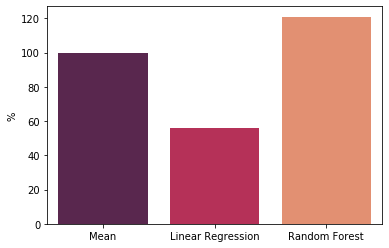

In [44]:
ax = sns.barplot(x=['Mean', 'Linear Regression', 'Random Forest'], y=percent_list, palette=PALETTE)
ax.set(ylabel='%')
plt.show()

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Лучше всего себя проявила модель случайного леса с итоговым sMAPE = 13.4. <br>
В сравнении с sMAPE по среднему значению модель случайного леса показала улучшение по метрике на ~21%. <br>

# 4. Общий вывод <a name="step4"></a>

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">
1. Выполнена подготовка данных. <br>
1.1. Проверены данные по эффективности обогащения чернового концентрата. <br>
1.2. Данные приведены к необходимому формату. <br>
1.3. Обнаруженные пропуски обработаны. <br>  
2. Выполнен анализ данных. <br>
2.1. Концентрация золота после каждого этапа обработки растет. Рост практически равномерен, следовательно выделить наиболее важный этап невозможно, каждый этап в равной степени важен при обработке. В отличии от золота, этапы обрботки по разному влияют на содержания серебра и свинца. <br>
2.2. Распределения размеров гранул сырья (feed size) на обучающей и тестовой выборках на этапах флотации и очистки находятся в одном и том же диапазоне, поэтому разделение на обучающую и тестовую выборки сделано верно. <br>
2.3. На всех распределениях элементов есть аномальные замеры концентраций с нулевыми значениями. Они так же есть и на распределениях суммарных концетраций, значит это одни и те же временные замеры. Если рассмотреть их, то большинство идет друг за другом, что склоняет к теории, о том что в это время в аппарате нет руды, простои в работе. Возможно ремонтные работы или профилактические, может отсутствие сырья для очистки. <br>
3. Подобрана модель для предсказания коэффициента восстановления золота из золотосодержащей руды.<br>
3.1. Лучше всего себя проявила модель случайного леса с итоговым sMAPE = 13.4. <br>
3.2. В сравнении с sMAPE по среднему значению модель случайного леса показала улучшение по метрике на ~21%.